# **K-Means: Implementação do Zero vs. Sklearn**

<p style="font-size: smaller; text-align: right;">João Dias & Rafael Rodrigues</p>

---

## **Objetivo**

Comparar o desempenho e a eficiência do algoritmo K-Means implementado do zero com a versão otimizada da biblioteca Sklearn.

---

## **Estrutura do Notebook**

1. **Introdução**  
   Breve explicação sobre o algoritmo K-Means e sua importância.

2. **Implementação Hardcore (Do Zero)**  
   Descrição da lógica e etapas da implementação manual.

3. **Implementação Usando Sklearn**  
   Utilização do algoritmo pré-implementado para comparação.

4. **Métricas de Avaliação**  
   Comparação com base no *Silhouette Score*, tempo de execução, e análise visual.

5. **Conclusão**  
   Reflexões sobre as diferenças de eficiência e desempenho entre as duas abordagens.

---

## **Introdução**

O K-Means é um dos algoritmos de clusterização mais populares, usado para particionar dados em *k* grupos com base em suas características. Ele busca minimizar a variação dentro dos clusters, agrupando dados semelhantes.

Neste notebook, serão comparadas duas implementações:
- **Hardcore:** Desenvolvida manualmente para entender o funcionamento interno do algoritmo.
- **Sklearn:** Utilizando a biblioteca popular para fins de comparação de desempenho e eficiência.


## **Implementação do Zero**

*<h4>Importação das Bibliotecas*

In [1]:
# Importação das bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import psutil
import time
from sklearn.cluster import KMeans

*<h4>Carregamento de Dados*

In [2]:
# Carregar a base de dados Iris (desconsiderando a variável target)
iris = datasets.load_iris()
iris_data = iris.data
iris_df = pd.DataFrame(iris_data, columns=iris.feature_names)

*<h4>Funções Auxiliares para o K-means*

In [3]:
# Função para inicializar centróides aleatórios de forma eficiente
def initialize_centroids(data, k):
    np.random.seed(42)  # Para resultados reprodutíveis
    random_indices = np.random.choice(data.shape[0], k, replace=False)
    return data[random_indices]

# Função para atribuir cada ponto ao centroide mais próximo
def assign_clusters(data, centroids):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

# Função para atualizar os centróides com base nos clusters
def update_centroids(data, clusters, k):
    return np.array([data[clusters == i].mean(axis=0) for i in range(k)])

# Função principal do K-means
def k_means(data, k, max_iter=100, tol=1e-4):
    centroids = initialize_centroids(data, k)
    for i in range(max_iter):
        clusters = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, clusters, k)
        if np.all(np.abs(new_centroids - centroids) < tol):
            print(f"Convergência alcançada após {i+1} iterações.")
            break
        centroids = new_centroids
    return centroids, clusters


*<h4>Funções para PCA e Visualização*

In [4]:
# Função para realizar a redução de dimensionalidade com PCA
def apply_pca(data, n_components):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)

# Função para plotar os clusters
def plot_clusters(data, clusters, centroids, k, title_suffix=""):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', marker='o', edgecolors='k', alpha=0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', label="Centroides")
    plt.title(f'Clusterização com k={k} {title_suffix}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# Função de visualização para PCA
def plot_clusters_pca(data, clusters, centroids, k, pca_components):
    plt.figure(figsize=(8, 6))
    if pca_components == 1:
        plt.scatter(data[:, 0], np.zeros_like(data[:, 0]), c=clusters, cmap='viridis', marker='o', edgecolors='k', alpha=0.6)
        plt.scatter(centroids[:, 0], np.zeros_like(centroids[:, 0]), s=300, c='red', marker='X', label="Centroides")
        plt.xlabel('Componente 1')
        plt.yticks([])
    else:
        plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', marker='o', edgecolors='k', alpha=0.6)
        plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', label="Centroides")
        plt.xlabel('Componente 1')
        plt.ylabel('Componente 2')
    plt.title(f'Clusterização com k={k} (PCA {pca_components}D)')
    plt.legend()
    plt.show()


*<h4>Função para Análise de Uso de Memória e Execução de Experimentos*

In [17]:
# Função para calcular uso de memória
def memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 ** 2)  # Em MB

# Função para rodar experimentos
def run_experiments(data, pca_data_1d, pca_data_2d, k_values):
    initial_memory = memory_usage()
    print(f"Memória inicial: {initial_memory:.2f} MB\n")

    for k in k_values:
        print(f"Resultados para k={k}:\n")
        
        # K-means no dataset original
        start_time = time.time()
        centroids, clusters = k_means(data, k)
        exec_time_original = time.time() - start_time
        score_original = silhouette_score(data, clusters)
        print(f"Silhouette Score (Original): {score_original:.4f} | Tempo: {exec_time_original:.4f}s")

        # K-means no dataset PCA 2D
        start_time = time.time()
        centroids_pca_2d, clusters_pca_2d = k_means(pca_data_2d, k)
        exec_time_pca_2d = time.time() - start_time
        score_pca_2d = silhouette_score(pca_data_2d, clusters_pca_2d)
        print(f"Silhouette Score (PCA 2D): {score_pca_2d:.4f} | Tempo: {exec_time_pca_2d:.4f}s")

        # K-means no dataset PCA 1D
        start_time = time.time()
        centroids_pca_1d, clusters_pca_1d = k_means(pca_data_1d, k)
        exec_time_pca_1d = time.time() - start_time
        score_pca_1d = silhouette_score(pca_data_1d, clusters_pca_1d)
        print(f"Silhouette Score (PCA 1D): {score_pca_1d:.4f} | Tempo: {exec_time_pca_1d:.4f}s\n")

        # Visualizações
        plot_clusters(data, clusters, centroids, k, "(Original)")
        plot_clusters_pca(pca_data_2d, clusters_pca_2d, centroids_pca_2d, k, 2)
        plot_clusters_pca(pca_data_1d, clusters_pca_1d, centroids_pca_1d, k, 1)
    
    final_memory = memory_usage()
    print(f"Memória final: {final_memory:.2f} MB\n")


*<h4>Redução de Dimensionalidade e Execução dos Experimentos*

Memória inicial: 211.32 MB

Resultados para k=3:

Convergência alcançada após 6 iterações.
Silhouette Score (Original): 0.5528 | Tempo: 0.0028s
Convergência alcançada após 7 iterações.
Silhouette Score (PCA 2D): 0.5977 | Tempo: 0.0025s
Convergência alcançada após 8 iterações.
Silhouette Score (PCA 1D): 0.6771 | Tempo: 0.0043s



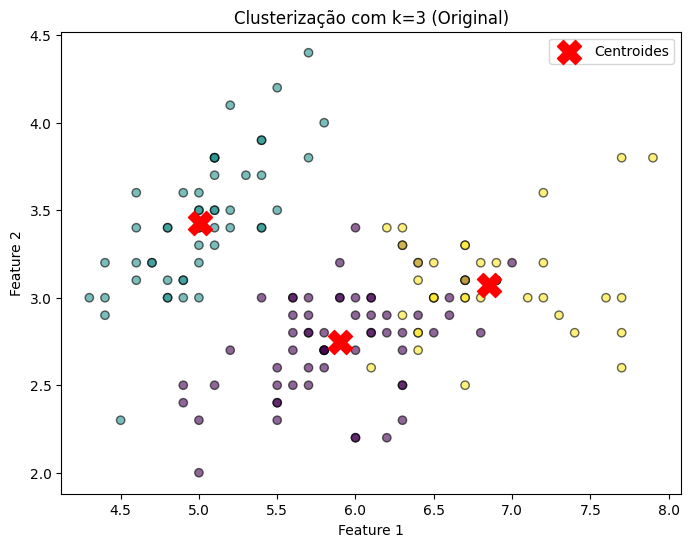

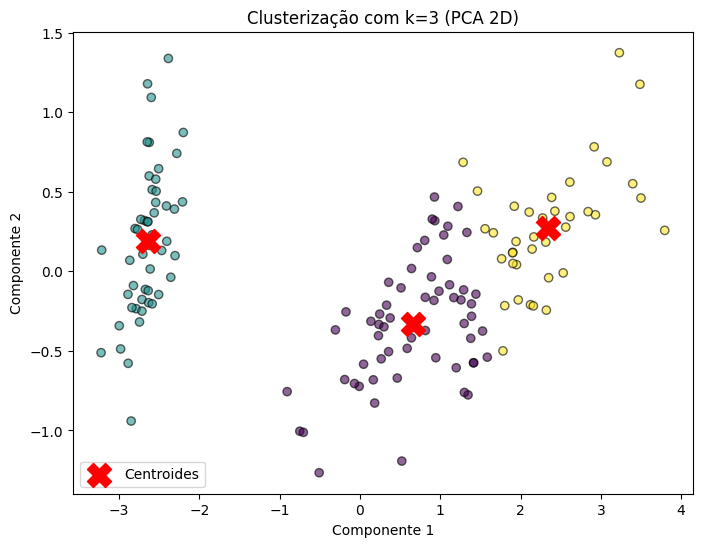

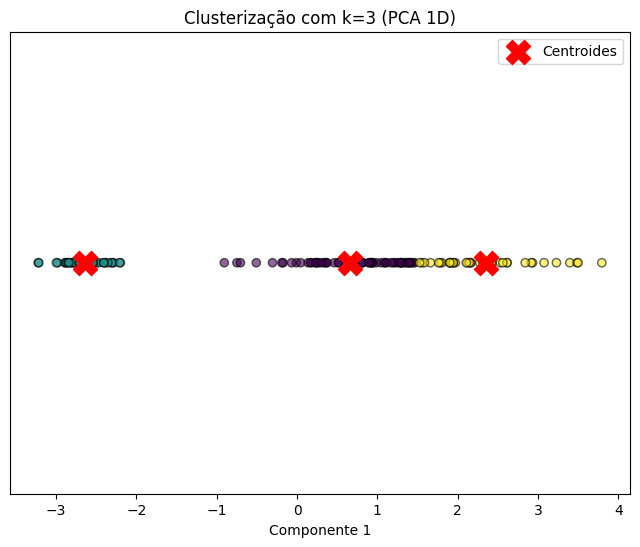

Resultados para k=5:

Convergência alcançada após 5 iterações.
Silhouette Score (Original): 0.4931 | Tempo: 0.0016s
Convergência alcançada após 7 iterações.
Silhouette Score (PCA 2D): 0.5510 | Tempo: 0.0013s
Convergência alcançada após 8 iterações.
Silhouette Score (PCA 1D): 0.6815 | Tempo: 0.0013s



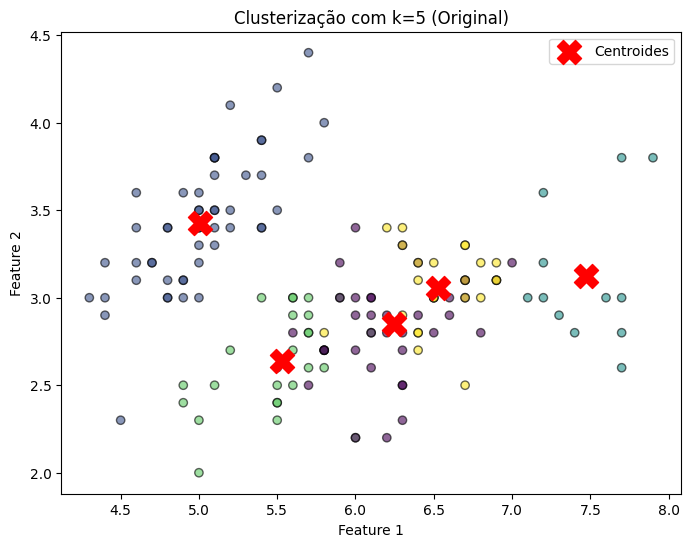

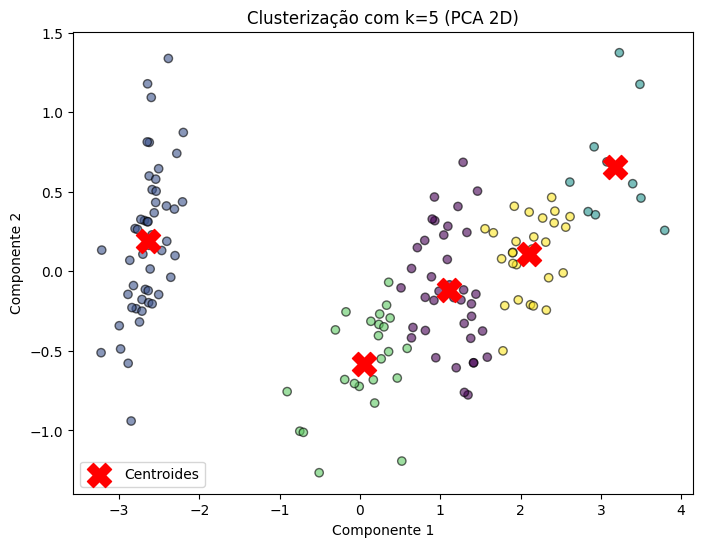

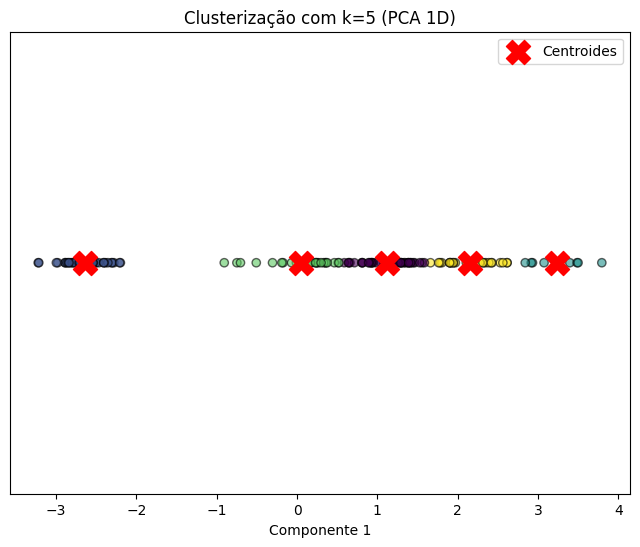

Memória final: 215.07 MB



In [18]:
# Reduzindo dimensionalidade com PCA
iris_pca_2d = apply_pca(iris_data, 2)
iris_pca_1d = apply_pca(iris_data, 1)

# Executando os experimentos para k=3 e k=5
run_experiments(iris_data, iris_pca_1d, iris_pca_2d, [3, 5])

## **Implementação com Sklearn**

<h4>Função para Análise de Uso de Memória e Execução de Experimentos

In [15]:
# Função para rodar experimentos
def run_sklearn_experiments(data, pca_data_1d, pca_data_2d, k_values):
    initial_memory = memory_usage()
    print(f"Memória inicial: {initial_memory:.2f} MB\n")

    for k in k_values:
        print(f"Resultados para k={k}:\n")
        
        # K-means no dataset original
        start_time = time.time()
        kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto", tol=1e-4)
        clusters = kmeans.fit_predict(data)
        centroids = kmeans.cluster_centers_
        exec_time_original = time.time() - start_time
        score_original = silhouette_score(data, clusters)
        print(f"Convergência alcançada após {kmeans.n_iter_} iterações.")
        print(f"Silhouette Score (Original): {score_original:.4f} | Tempo: {exec_time_original:.4f}s")

        # K-means no dataset PCA 2D
        start_time = time.time()
        kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto", tol=1e-4)
        clusters_pca_2d = kmeans.fit_predict(pca_data_2d)
        centroids_pca_2d = kmeans.cluster_centers_
        exec_time_pca_2d = time.time() - start_time
        score_pca_2d = silhouette_score(pca_data_2d, clusters_pca_2d)
        print(f"Convergência alcançada após {kmeans.n_iter_} iterações.")
        print(f"Silhouette Score (PCA 2D): {score_pca_2d:.4f} | Tempo: {exec_time_pca_2d:.4f}s")

        # K-means no dataset PCA 1D
        start_time = time.time()
        kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto", tol=1e-4)
        clusters_pca_1d = kmeans.fit_predict(pca_data_1d)
        centroids_pca_1d = kmeans.cluster_centers_
        exec_time_pca_1d = time.time() - start_time
        score_pca_1d = silhouette_score(pca_data_1d, clusters_pca_1d)
        print(f"Convergência alcançada após {kmeans.n_iter_} iterações.")
        print(f"Silhouette Score (PCA 1D): {score_pca_1d:.4f} | Tempo: {exec_time_pca_1d:.4f}s\n")

        # Visualizações
        plot_clusters(data, clusters, centroids, k, "(Original)")
        plot_clusters_pca(pca_data_2d, clusters_pca_2d, centroids_pca_2d, k, 2)
        plot_clusters_pca(pca_data_1d, clusters_pca_1d, centroids_pca_1d, k, 1)
    
    final_memory = memory_usage()
    print(f"Memória final: {final_memory:.2f} MB\n")


*<h4>Redução de Dimensionalidade e Execução dos Experimentos*

Memória inicial: 211.32 MB

Resultados para k=3:

Convergência alcançada após 7 iterações.
Silhouette Score (Original): 0.5512 | Tempo: 0.0079s
Convergência alcançada após 8 iterações.
Silhouette Score (PCA 2D): 0.5977 | Tempo: 0.0278s
Convergência alcançada após 11 iterações.
Silhouette Score (PCA 1D): 0.6771 | Tempo: 0.0154s



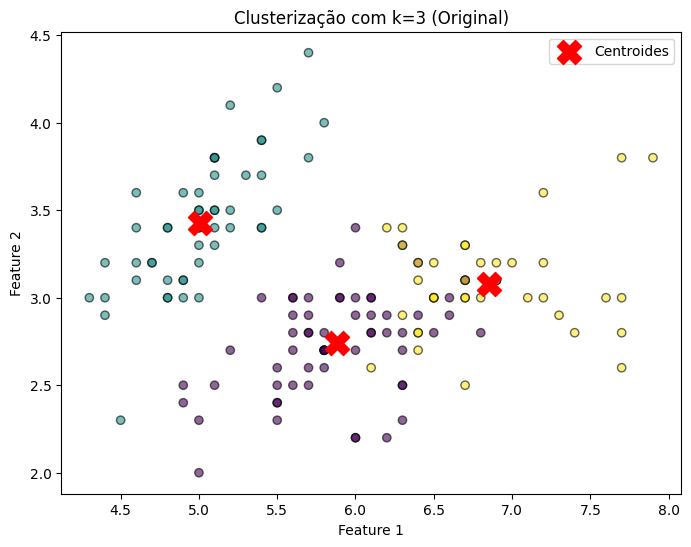

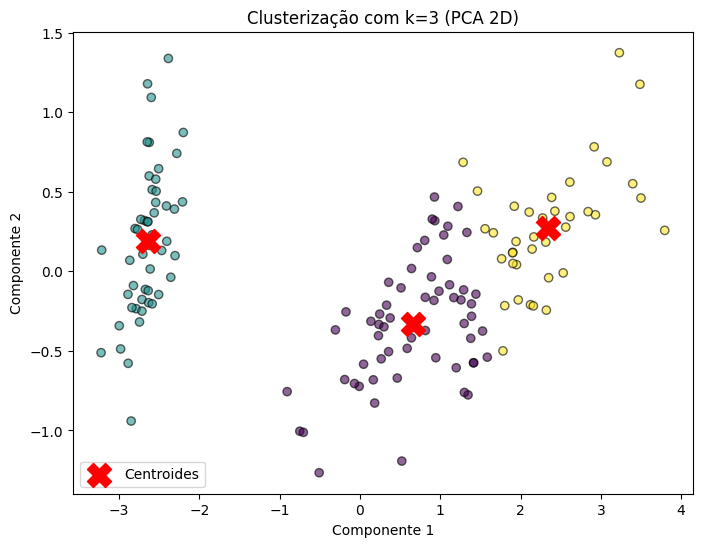

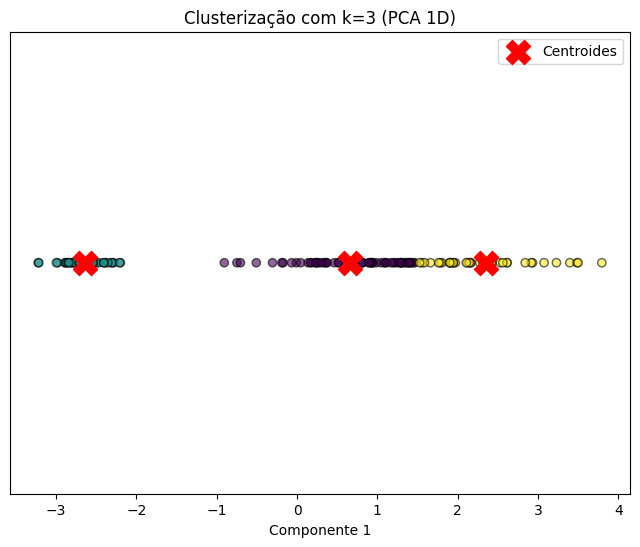

Resultados para k=5:

Convergência alcançada após 7 iterações.
Silhouette Score (Original): 0.4610 | Tempo: 0.0111s
Convergência alcançada após 6 iterações.
Silhouette Score (PCA 2D): 0.5460 | Tempo: 0.0248s
Convergência alcançada após 5 iterações.
Silhouette Score (PCA 1D): 0.6823 | Tempo: 0.0162s



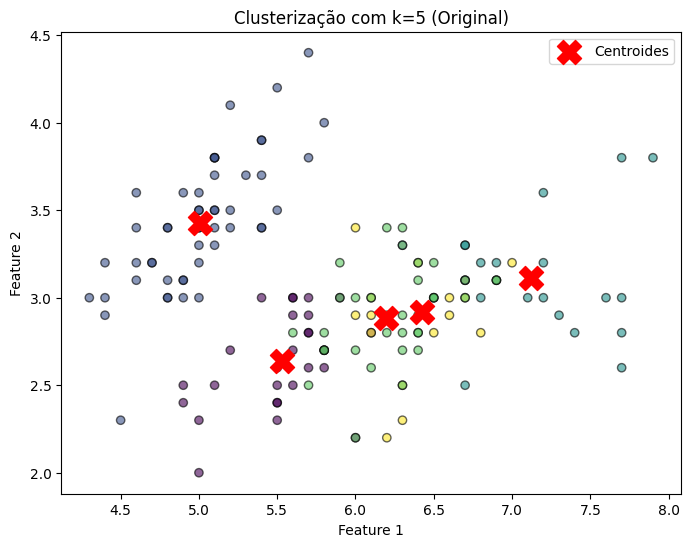

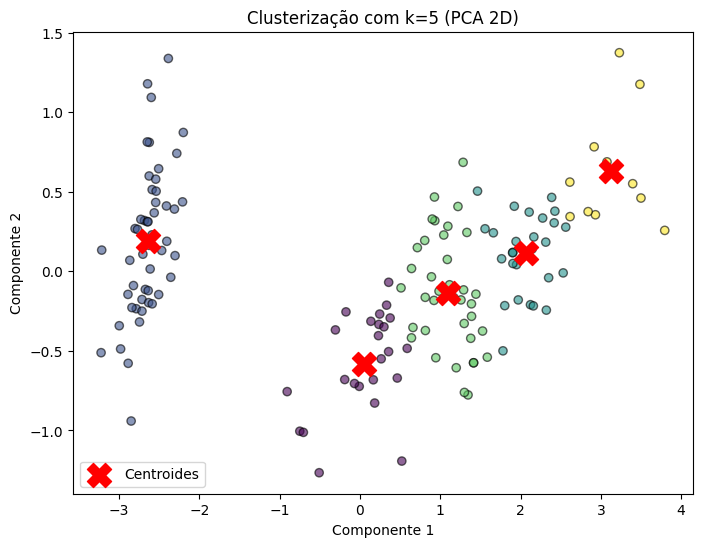

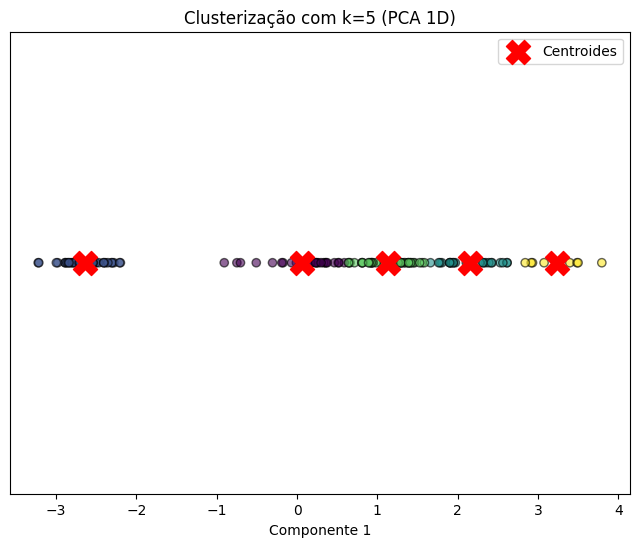

Memória final: 211.32 MB



In [ ]:
# Reduzindo dimensionalidade com PCA
iris_pca_2d = apply_pca(iris_data, 2)
iris_pca_1d = apply_pca(iris_data, 1)

# Executando os experimentos para k=3 e k=5
run_sklearn_experiments(iris_data, iris_pca_1d, iris_pca_2d, [3, 5])